In [1]:
#@title Install prerequsite: you may have to do Runtime -> Restart runtime after the installation
!pip install --upgrade pip
!pip install --upgrade setuptools wheel
!pip install --upgrade "mxnet<2.0.0"
!pip install autogluon

In [2]:
import autogluon

In [3]:
#@title Mount Google Drive (You don't need to run this if you are running notebooks on your laptop)

from google.colab import drive

# The following command will prompt a URL for you to click and obtain the
# authorization code

drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Set up data folder
from pathlib import Path

# Change this to where you put your hw2 files
DATA = Path("/content/drive/My Drive/project")

# Project part 1 

## Reclassifying Mutations



First the existing mutation files from the paper were loaded. The mutations from the files were combined a kept seperate by gene. The total mutations for each type of gene found in this analysis match the mutations statistics record in the meta files from the paper. 

In [5]:
import pandas as pd
snvsfile = DATA / "snvs.txt"
snvs = pd.read_csv(snvsfile, sep="\t", comment="#")
snvs = snvs[['Gene', 'Sample_ID']]
snvs = snvs.dropna()

In [6]:
import pandas as pd
indelsfile = DATA / "indels.txt"
indels = pd.read_csv(indelsfile, sep="\t", comment="#")
indels = indels[['Gene', 'Sample_ID']]
indels = indels.dropna()

In [7]:
groupedsnvs = snvs.groupby(by=['Gene']).count()
groupedsnvs = groupedsnvs.sort_values(by = ["Sample_ID"], ascending=False)
groupedsnvs.head()

,Sample_ID
Gene,
SMARCB1,5
KRT39,2
MUC16,2
OR4C6,2
ARMCX4,2


In [8]:
groupedindels = indels.groupby(by=['Gene']).count()
groupedindels = groupedindels.sort_values(by = ["Sample_ID"], ascending=False)
groupedindels.head()

,Sample_ID
Gene,
SMARCB1,2
ANK2,1
AUTS2,1
ZBTB48,1
TBX15,1


In [9]:
concat = pd.concat([snvs, indels])

In [10]:
count = concat.groupby(by='Gene')
count = count.describe()
count = count['Sample_ID']
count = count.sort_values(by ='unique', ascending=False)
count = count[['unique']]
count.head()

,unique
Gene,
SMARCB1,7
MUC16,2
ARMCX4,2
PPARGC1A,1
RAB11FIP2,1


In [11]:
count['snvs'] = groupedsnvs.Sample_ID
count['indel'] = groupedindels.Sample_ID
summary = count.fillna(0)
summary = summary.astype(int)
summary

,unique,snvs,indel
Gene,,,
SMARCB1,7,5,2
MUC16,2,2,0
ARMCX4,2,2,0
PPARGC1A,1,1,0
RAB11FIP2,1,1,0
...,...,...,...
IFIT3,1,1,0
IL36B,1,0,1
ISL2,1,1,0


# Project Part 2

## Machine Learning

The paper uses methylation data to divide the atrt tumors into three seperate subcatagories. The gene expression data contains similar data but unlike the methylation data it is not specific to a location. We started by loading the gene expression and methylation data for 49 cases from the 180 ATRT patients in the paper. The subtype labels from the paper are then matched with these 49 samples by sample name. The 49 samples are now split into 3 groups and can be used in a multiclass training method by autogluon. The data was split into 40 training cases and 9 test cases, 3 from each class. 

In [12]:
import pandas as pd

gefile = DATA / "GSE70678_matrix.txt"
methfile = DATA / "GSE70460_series_matrix.txt.gz"

ge = pd.read_csv(gefile, sep="\t", na_values="unknown", index_col=0)
meth = pd.read_csv(methfile, sep="\t", na_values="unknown", index_col=0, header= 64)
gemeta = ge.head(36)
ge.columns = ge.iloc[35]
ge = ge.iloc[36:-1 ,:]

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
gemeta.head()

,dkfz_ATRT_159,dkfz_ATRT_17,dkfz_ATRT_25,dkfz_ATRT_173,dkfz_ATRT_151,dkfz_ATRT_171,dkfz_ATRT_152,dkfz_ATRT_172,dkfz_ATRT_153,dkfz_ATRT_86,dkfz_ATRT_10,dkfz_ATRT_154,dkfz_ATRT_30,dkfz_ATRT_36,dkfz_ATRT_11,dkfz_ATRT_12,dkfz_ATRT_41,dkfz_ATRT_43,dkfz_ATRT_164,dkfz_ATRT_16,dkfz_ATRT_6,dkfz_ATRT_160,dkfz_ATRT_7,dkfz_ATRT_48,dkfz_ATRT_49,dkfz_ATRT_51,dkfz_ATRT_47,dkfz_ATRT_46,dkfz_ATRT_101,dkfz_ATRT_157,dkfz_ATRT_155,dkfz_ATRT_168,dkfz_ATRT_156,dkfz_ATRT_163,dkfz_ATRT_162,dkfz_ATRT_158,dkfz_ATRT_166,dkfz_ATRT_169,dkfz_ATRT_170,dkfz_ATRT_88,dkfz_ATRT_72,dkfz_ATRT_167,dkfz_ATRT_85,dkfz_ATRT_84,dkfz_ATRT_165,dkfz_ATRT_14,dkfz_ATRT_32,dkfz_ATRT_161,dkfz_ATRT_90
!Sample_title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
!Sample_geo_accession,GSM1816332,GSM1816333,GSM1816334,GSM1816335,GSM1816336,GSM1816337,GSM1816338,GSM1816339,GSM1816340,GSM1816341,GSM1816342,GSM1816343,GSM1816344,GSM1816345,GSM1816346,GSM1816347,GSM1816348,GSM1816349,GSM1816350,GSM1816351,GSM1816352,GSM1816353,GSM1816354,GSM1816355,GSM1816356,GSM1816357,GSM1816358,GSM1816359,GSM1816360,GSM1816361,GSM1816362,GSM1816363,GSM1816364,GSM1816365,GSM1816366,GSM1816367,GSM1816368,GSM1816369,GSM1816370,GSM1816371,GSM1816372,GSM1816373,GSM1816374,GSM1816375,GSM1816376,GSM1816377,GSM1816378,GSM1816379,GSM1816380
!Sample_status,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016,Public on Mar 02 2016
!Sample_submission_date,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015,Jul 09 2015
!Sample_last_update_date,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018,Mar 13 2018
!Sample_type,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA,RNA


In [14]:
ge.head()

ID_REF,GSM1816332,GSM1816333,GSM1816334,GSM1816335,GSM1816336,GSM1816337,GSM1816338,GSM1816339,GSM1816340,GSM1816341,GSM1816342,GSM1816343,GSM1816344,GSM1816345,GSM1816346,GSM1816347,GSM1816348,GSM1816349,GSM1816350,GSM1816351,GSM1816352,GSM1816353,GSM1816354,GSM1816355,GSM1816356,GSM1816357,GSM1816358,GSM1816359,GSM1816360,GSM1816361,GSM1816362,GSM1816363,GSM1816364,GSM1816365,GSM1816366,GSM1816367,GSM1816368,GSM1816369,GSM1816370,GSM1816371,GSM1816372,GSM1816373,GSM1816374,GSM1816375,GSM1816376,GSM1816377,GSM1816378,GSM1816379,GSM1816380
!Sample_title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1007_s_at,426.5,1448.6,573.1,417.5,479.6,1243.2,529.4,1151.6,1126.9,588.7,669.3,112,1207.1,641,767.2,979.7,1199.5,1098.8,378.1,416.6,590.6,826.1,1116.2,873.6,671.6,536.3,114.2,2334.8,766.3,1193.7,637.7,686.2,313,455,217,1060.9,425.1,146.1,334.2,350.8,687.5,845.7,590.6,348.7,1382.3,567.2,1284.5,1014.9,605.3
1053_at,95.9,173.3,75.7,57.7,160.9,141,188.5,126.1,122.6,107.8,163.9,120.6,118.9,177.4,154.9,112.3,97.9,120.3,181.9,156.3,100,125.5,154.1,155.1,103.2,180.1,236.3,81,112.4,154.9,141.2,230.8,127.3,158.8,181.2,187.2,140.2,132.6,81.8,147.8,75.3,209.3,197.1,189.5,86.5,171.7,145.9,157,168.4
117_at,28.3,18.6,42.7,169.2,15.7,17.2,21.4,70.2,54.4,795.3,30.9,26.6,12.8,17,17.2,38,28.4,95.8,74.8,49.3,44,198.2,23.1,34.8,37.4,12.6,83.5,43.7,75.1,23.5,22.5,27.1,37.7,46.3,26.9,9.7,65.4,69.2,34.3,89.5,28.9,18.5,31.7,21.9,102.9,49.7,1333.4,18.8,63
121_at,94.3,45.3,57.7,72,55.1,63.3,80.4,36.3,68.6,91,95.9,133.8,134.6,100,69.5,91.4,79.2,55.5,71.9,61.6,61.7,98.8,52.1,92.9,140.6,125.4,86.2,61.4,61.2,120.5,72.6,78,88.2,93.9,64.1,66.9,101.1,124.1,143.5,101.4,77.6,121.2,80.9,68.3,132,118.7,64.3,60.2,77.8
1255_g_at,2.5,0.7,5.7,58.4,3.1,2.4,3.2,10.5,7.3,7.5,6.8,1.1,5.2,6.9,3.5,3.4,1.4,10.9,12.5,18.6,2.4,21.5,0.8,7.1,8.7,4,7.8,6.8,1.9,8.4,11.2,4.4,4.5,8.2,1.5,6.5,2.4,9.5,4.2,7.4,8.3,8.4,4.3,1.8,6.9,1.5,1.3,37.8,9.2


In [15]:
meth.head()

,GSM1755170,GSM1755171,GSM1755172,GSM1755173,GSM1755174,GSM1755175,GSM1755176,GSM1755177,GSM1755178,GSM1755179,GSM1755180,GSM1755181,GSM1755182,GSM1755183,GSM1755184,GSM1755185,GSM1755186,GSM1755187,GSM1755188,GSM1755189,GSM1755190,GSM1755191,GSM1755192,GSM1755193,GSM1755194,GSM1755195,GSM1755196,GSM1755197,GSM1755198,GSM1755199,GSM1755200,GSM1755201,GSM1755202,GSM1755203,GSM1755204,GSM1755205,GSM1755206,GSM1755208,GSM1755209,GSM1755210,...,GSM1755367,GSM1755371,GSM1755375,GSM1755378,GSM1755382,GSM1755385,GSM1755388,GSM1755392,GSM1755395,GSM2051672,GSM2051673,GSM2051674,GSM2051675,GSM2051676,GSM2051677,GSM2051678,GSM2051679,GSM2051680,GSM2051681,GSM2051682,GSM2051683,GSM2051684,GSM2051685,GSM2051686,GSM2051687,GSM2051688,GSM2051689,GSM2051690,GSM2051691,GSM2051692,GSM2051693,GSM2051694,GSM2051695,GSM2051696,GSM2051697,GSM2051698,GSM2051699,GSM2051700,GSM2051701,GSM2051702
ID_REF,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
cg00000029,0.233639,0.707772,0.251903,0.526724,0.404274,0.356997,0.444767,0.188338,0.689528,0.222346,0.748297,0.494161,0.428071,0.283786,0.743197,0.302302,0.437280,0.315523,0.591644,0.351332,0.408740,0.249594,0.240342,0.170581,0.317655,0.244369,0.573248,0.314415,0.329547,0.652745,0.740240,0.370276,0.391482,0.303231,0.164043,0.114542,0.262227,0.676064,0.326391,0.341752,...,0.470345,0.442620,0.549346,0.389695,0.297349,0.516124,0.384618,0.523748,0.204516,0.577293,0.330351,0.271943,0.390737,0.589534,0.145170,0.265167,0.298249,0.316445,0.340578,0.394026,0.512050,0.276085,0.414950,0.542832,0.162054,0.462029,0.244735,0.332264,0.393462,0.569178,0.209321,0.352109,0.439519,0.256184,0.186200,0.211489,0.148386,0.293506,0.426848,0.375697
cg00000108,0.938803,0.911581,0.929206,0.935562,0.941001,0.925437,0.913178,0.917131,0.953745,0.963604,0.930982,0.949970,0.941192,0.908703,0.935924,0.936123,0.961198,0.842026,0.949979,0.893223,0.931049,0.947004,0.907066,0.940768,0.935493,0.929884,0.915023,0.950989,0.955798,0.925292,0.937417,0.936939,0.936586,0.924737,0.883539,0.951436,0.921340,0.915088,0.889984,0.920692,...,0.915920,0.855734,0.835532,0.870266,0.880080,0.851440,0.938475,0.901274,0.940875,0.855938,0.821875,0.891613,0.879165,0.804980,0.855547,0.862085,0.903575,0.870697,0.890521,0.900931,0.886325,0.880761,0.876552,0.852082,0.871461,0.855256,0.782079,0.862102,0.862107,0.832371,0.879776,0.752832,0.839864,0.733557,0.868390,0.787937,0.864105,0.788029,0.828619,0.825274
cg00000109,0.883326,0.877838,0.731915,0.752427,0.796499,0.887018,0.838659,0.850539,0.893031,0.906258,0.801748,0.429852,0.833911,0.818169,0.537447,0.870020,0.888209,0.819853,0.631496,0.604464,0.849264,0.841755,0.882378,0.902550,0.881787,0.717837,0.738306,0.868691,0.610745,0.916624,0.628656,0.873302,0.891642,0.853650,0.583921,0.856182,0.912622,0.781826,0.813454,0.899448,...,0.548857,0.808218,0.559361,0.611600,0.641877,0.822538,0.583476,0.787079,0.870045,0.735572,0.641026,0.596404,0.829746,0.535771,0.789474,0.830111,0.824748,0.500782,0.832552,0.875909,0.787627,0.811469,0.815374,0.833258,0.845466,0.826607,0.692812,0.481772,0.824240,0.822971,0.816227,0.590704,0.834401,0.740834,0.682739,0.705098,0.810355,0.598137,0.551450,0.750243
cg00000165,0.528943,0.132206,0.670318,0.205442,0.424001,0.151361,0.371850,0.673996,0.858881,0.517007,0.338881,0.530169,0.123305,0.147213,0.880645,0.859784,0.093326,0.110808,0.193867,0.758933,0.276771,0.696539,0.597661,0.562081,0.840610,0.106546,0.111664,0.449088,0.112873,0.543175,0.610725,0.211313,0.816915,0.809718,0.204638,0.938450,0.702455,0.448489,0.096944,0.778999,...,0.450405,0.387707,0.789935,0.567875,0.470227,0.475603,0.166931,0.218099,0.872623,0.190535,0.380332,0.103104,0.090690,0.557864,0.744303,0.470095,0.741788,0.162595,0.441244,0.101852,0.157865,0.624784,0.372658,0.713473,0.771577,0.357595,0.178367,0.183553,0.528264,0.720386,0.098405,0.452315,0.279491,0.103816,0.730732,0.237288,0.588285,0.462184,0.136910,0.552412
cg00000236,0.634338,0.744383,0.876071,0.822100,0.903711,0.909017,0.813823,0.651720,0.89

Thte meta file is loaded in here along with other variable to include in the autogluon training in case the help. 

In [16]:
classfile = DATA / "metaandclassify.txt"
classified = pd.read_csv(classfile, sep="\t", comment="#",index_col=0)
classified = classified[['Molecular Subgroup (Consensus)','Gender (F= FeMale, M=Male)','Age at diagnosis']]
classified.head()

,Molecular Subgroup (Consensus),"Gender (F= FeMale, M=Male)",Age at diagnosis
Sample Name,,,
dkfz_ATRT_1,SHH,F,2.0
dkfz_ATRT_2,SHH,M,2.0
dkfz_ATRT_3,SHH,F,NaN
dkfz_ATRT_4,MYC,M,4.0
dkfz_ATRT_5,SHH,M,4.0


In [17]:
meta = gemeta.transpose()
classified = classified[classified.index.isin(meta.index)]
classified.sort_index(inplace=True)
meta.sort_index(inplace=True)
meta['Class'] = classified['Molecular Subgroup (Consensus)']
meta['Age'] = classified['Age at diagnosis']
meta['Gender'] = classified['Gender (F= FeMale, M=Male)']
meta = meta.rename(columns={"!Sample_geo_accession": "SampleGeo"})
meta.rename(columns = {list(meta)[9]: 'cha1'}, inplace = True)

### Split the Test Set

3 samples are chosen from each class of tumor to become the test dataset.
We have 5 different ways to choose them shown below.

In [18]:
test_sample_id_0 = meta.groupby("Class").apply(lambda g: g.SampleGeo.iloc[-3:])
test_sample_id_0

Class              
MYC    dkfz_ATRT_46    GSM1816359
       dkfz_ATRT_49    GSM1816356
       dkfz_ATRT_90    GSM1816380
SHH    dkfz_ATRT_51    GSM1816357
       dkfz_ATRT_7     GSM1816354
       dkfz_ATRT_72    GSM1816372
TYR    dkfz_ATRT_85    GSM1816374
       dkfz_ATRT_86    GSM1816341
       dkfz_ATRT_88    GSM1816371
Name: SampleGeo, dtype: object

In [19]:
# pick 3 samples from each class (MYC, SHH, TYR) as test set for evaluation in the end
test_sample_id_1 = meta.groupby("Class").apply(lambda g: g.SampleGeo.iloc[:3])
test_sample_id_1

Class               
MYC    dkfz_ATRT_154    GSM1816343
       dkfz_ATRT_156    GSM1816364
       dkfz_ATRT_160    GSM1816353
SHH    dkfz_ATRT_11     GSM1816346
       dkfz_ATRT_12     GSM1816347
       dkfz_ATRT_153    GSM1816340
TYR    dkfz_ATRT_10     GSM1816342
       dkfz_ATRT_101    GSM1816360
       dkfz_ATRT_14     GSM1816377
Name: SampleGeo, dtype: object

In [20]:
test_sample_id_2 = meta.groupby("Class").apply(lambda g: g.SampleGeo.iloc[3:6])
test_sample_id_2

Class               
MYC    dkfz_ATRT_162    GSM1816366
       dkfz_ATRT_163    GSM1816365
       dkfz_ATRT_165    GSM1816376
SHH    dkfz_ATRT_157    GSM1816361
       dkfz_ATRT_158    GSM1816367
       dkfz_ATRT_159    GSM1816332
TYR    dkfz_ATRT_151    GSM1816336
       dkfz_ATRT_152    GSM1816338
       dkfz_ATRT_155    GSM1816362
Name: SampleGeo, dtype: object

In [21]:
test_sample_id_3 = meta.groupby("Class").apply(lambda g: g.SampleGeo.iloc[6:9])
test_sample_id_3

Class               
MYC    dkfz_ATRT_166    GSM1816368
       dkfz_ATRT_167    GSM1816373
       dkfz_ATRT_169    GSM1816369
SHH    dkfz_ATRT_161    GSM1816379
       dkfz_ATRT_164    GSM1816350
       dkfz_ATRT_17     GSM1816333
TYR    dkfz_ATRT_16     GSM1816351
       dkfz_ATRT_168    GSM1816363
       dkfz_ATRT_173    GSM1816335
Name: SampleGeo, dtype: object

In [22]:
test_sample_id_4 = meta.groupby("Class").apply(lambda g: g.SampleGeo.iloc[9:12])
test_sample_id_4

Class               
MYC    dkfz_ATRT_170    GSM1816370
       dkfz_ATRT_41     GSM1816348
       dkfz_ATRT_43     GSM1816349
SHH    dkfz_ATRT_171    GSM1816337
       dkfz_ATRT_172    GSM1816339
       dkfz_ATRT_32     GSM1816378
TYR    dkfz_ATRT_25     GSM1816334
       dkfz_ATRT_30     GSM1816344
       dkfz_ATRT_47     GSM1816358
Name: SampleGeo, dtype: object

First, use test_sample_id_0.

In [23]:
# define train and test set
meta["subset"] = "train"
meta.loc[meta.SampleGeo.isin(test_sample_id_0), "subset"] = "test"

In [24]:
meta.groupby(["subset", "Class"]).SampleGeo.nunique()

subset  Class
test    MYC       3
        SHH       3
        TYR       3
train   MYC      12
        SHH      13
        TYR      15
Name: SampleGeo, dtype: int64

### Feature selection

Using the method from class we calculate the mutual information between each gene and the severity using scikit-learn's [`mutual_info_classif`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html#sklearn.feature_selection.mutual_info_classif) function. All genes are ranked and a cutoff is selected.

In [25]:
#=======================================================
# Perform feature selection using mutual_info_classif 
#=======================================================
di = {"TYR": 0, "SHH": 1,"MYC":2}
meta = meta.replace({"Class": di})
target = (meta["Class"]).astype(int)

In [26]:
# Creating trianing and testing data.
y_train = target[(meta.subset == "train")].values
y_test = target[(meta.subset == "test")].values
x_train = ge[meta[meta.subset == "train"].SampleGeo].transpose()
x_test = ge[meta[meta.subset == "test"].SampleGeo].transpose()

In [27]:
from sklearn.feature_selection import mutual_info_classif

In [28]:
midf = pd.DataFrame({
    "feature": x_train.columns,
    "mi": mutual_info_classif(x_train, y_train,)
}).sort_values("mi", ascending=False)

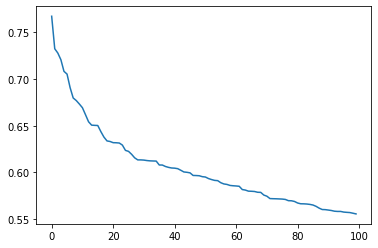

In [29]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(100), midf.mi.iloc[:100])

In [30]:
selected_genes = midf.feature.loc[midf.mi > 0.60]
len(selected_genes)

45

### Training an ATRT classifier using AutoML

Procedures used in class were repeated here to create an AutoML model for classifying ATRT data.

In [31]:
#===========================================================================
# Train a classification model using AutoGluon TabularPrediction module with
# features selected by the RandomForestClassifier
#===========================================================================
from autogluon.tabular import TabularPredictor
train_data = x_train.loc[:, selected_genes].copy()
train_data["Class"] = y_train
predictor = TabularPredictor(label="Class", path="good_quality_atrt").fit( 
    train_data=train_data,
    presets="good_quality_faster_inference_only_refit",
)

Presets specified: ['good_quality_faster_inference_only_refit']
Beginning AutoGluon training ...
AutoGluon will save models to "good_quality_atrt/"
AutoGluon Version:  0.3.1
Train Data Rows:    40
Train Data Columns: 45
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	3 unique label values:  [0, 1, 2]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Class Count: 3
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11375.47 MB
	Train Data (Original)  Memory Usage: 0.07 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generat

Performance scores are calculated to evaluate the model. 

In [32]:
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, 
                             roc_auc_score, f1_score)
def performance_scores(y_true, y_pred_score, y_pred=None):
    # We can find which class has the highest score as its predicted class
    if y_pred is None:
        y_pred = y_pred_score.idxmax(axis=1)
        
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
        #"auroc": roc_auc_score(y_true, y_pred_score[:, 1], average="weighted",
        #                       multi_class="ovr"),
        "f1": f1_score(y_true, y_pred, average="weighted")
    }

In [33]:
test_data = x_test.loc[:, selected_genes].copy()
y_pred_score = predictor.predict_proba(test_data).values
y_pred = predictor.predict(test_data)
y_pred
performance_scores(y_test, y_pred_score, y_pred)

{'accuracy': 0.3333333333333333,
 'balanced_accuracy': 0.3333333333333333,
 'f1': 0.1818181818181818}

In [34]:
y_pred_score

array([[0.33780035, 0.37398416, 0.28821555],
       [0.40960276, 0.2832945 , 0.30710277],
       [0.40960276, 0.2832945 , 0.30710277],
       [0.40960276, 0.2832945 , 0.30710277],
       [0.40960276, 0.2832945 , 0.30710277],
       [0.40960276, 0.2832945 , 0.30710277],
       [0.4096028 , 0.2832945 , 0.30710277],
       [0.4096028 , 0.2832945 , 0.30710277],
       [0.4096028 , 0.2832945 , 0.30710277]], dtype=float32)

Now also plot the confusion matrix to show correct and incorrect predictions in the test set

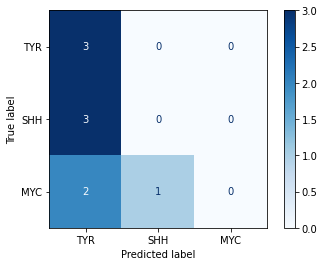

In [35]:
#============================================================================
# Plot confusion matrix for the trained model
#============================================================================

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(cm, display_labels=["TYR", "SHH","MYC"])
disp.plot(cmap="Blues")

The models are displayed here in a leader board to show which performed best.


In [36]:
predictor.leaderboard()

                           model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0            WeightedEnsemble_L2      0.650       1.015267  10.408949                0.000561           0.292818            2      False         12
1                CatBoost_BAG_L1      0.625       0.063221   3.989637                0.063221           3.989637            1      False          6
2          ExtraTreesGini_BAG_L1      0.625       0.102219   0.754899                0.102219           0.754899            1      False          7
3          ExtraTreesEntr_BAG_L1      0.625       0.111699   0.767845                0.111699           0.767845            1      False          8
4     ExtraTreesGini_BAG_L1_FULL      0.625       0.118864   0.756410                0.118864           0.756410            1       True         19
5     ExtraTreesEntr_BAG_L1_FULL      0.625       0.128126   0.756333                0.128126           0.756333

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.650,1.015267,10.408949,0.000561,0.292818,2,False,12
1,CatBoost_BAG_L1,0.625,0.063221,3.989637,0.063221,3.989637,1,False,6
2,ExtraTreesGini_BAG_L1,0.625,0.102219,0.754899,0.102219,0.754899,1,False,7
3,ExtraTreesEntr_BAG_L1,0.625,0.111699,0.767845,0.111699,0.767845,1,False,8
4,ExtraTreesGini_BAG_L1_FULL,0.625,0.118864,0.756410,0.118864,0.756410,1,True,19
5,ExtraTreesEntr_BAG_L1_FULL,0.625,0.128126,0.756333,0.128126,0.756333,1,True,20
6,NeuralNetMXNet_BAG_L1,0.625,0.951485,6.126493,0.951485,6.126493,1,False,10
7,RandomForestGini_BAG_L1,0.600,0.096963,0.821467,0.096963,0.821467,1,False,4
8,RandomForestEntr_BAG_L1_FULL,0.600,0.098300,0.749660,0.098300,0.749660,1,True,17
9,RandomForestGini_BAG_L1_FULL,0.600,0.102393,0.753424,0.102393,0.753424,1,True,16


In [37]:
featimp = predictor.feature_importance(train_data, num_shuffle_sets=10)
featimp[featimp.importance > 0].sort_values("p_value")

Computing feature importance via permutation shuffling for 45 features using 40 rows with 10 shuffle sets...
	106.77s	= Expected runtime (10.68s per shuffle set)
	4.08s	= Actual runtime (Completed 10 of 10 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
1557275_a_at,0.1025,0.024861,1.893466e-07,10,0.128049,0.076951
226535_at,0.1375,0.044488,2.163815e-06,10,0.183220,0.091780
226824_at,0.0775,0.044799,1.974788e-04,10,0.123539,0.031461
241359_at,0.0150,0.021082,2.550163e-02,10,0.036666,-0.006666
225877_at,0.0025,0.007906,1.717182e-01,10,0.010625,-0.005625


The best model in this dataset was the 'ExtraTreesEntr_BAG_L1_FULL' and we can see that 

the most important features were all the at genes, which is what expected in ATRT patients. 

### Project Part 2 **Plus**: Improve the model to achieve higher accuracy.

### Change the Way of Deviding the Data into Test and Training Data Subsets

In [38]:
# define train and test set
meta["subset"] = "train"
meta.loc[meta.SampleGeo.isin(test_sample_id_1), "subset"] = "test"

In [39]:
meta.groupby(["subset", "Class"]).SampleGeo.nunique()

subset  Class
test    0         3
        1         3
        2         3
train   0        15
        1        13
        2        12
Name: SampleGeo, dtype: int64

In [40]:
# Creating trianing and testing data. 
y_train = target[(meta.subset == "train")].values
y_test = target[(meta.subset == "test")].values
x_train = ge[meta[meta.subset == "train"].SampleGeo].transpose()
x_test = ge[meta[meta.subset == "test"].SampleGeo].transpose()

In [41]:
from sklearn.feature_selection import mutual_info_classif

In [42]:
midf = pd.DataFrame({
    "feature": x_train.columns,
    "mi": mutual_info_classif(x_train, y_train,)
}).sort_values("mi", ascending=False)

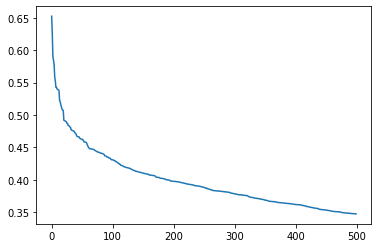

In [43]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(500), midf.mi.iloc[:500])

In [44]:
selected_genes = midf.feature.loc[midf.mi > 0.384]
len(selected_genes)

263

In [45]:
#===========================================================================
# Train a classification model using AutoGluon TabularPrediction module with
# features selected by the RandomForestClassifier
#===========================================================================
from autogluon.tabular import TabularPredictor
train_data = x_train.loc[:, selected_genes].copy()
train_data["Class"] = y_train

predictor = TabularPredictor(label="Class", path="good_quality_atrt").fit( 
    train_data=train_data,
    presets="good_quality_faster_inference_only_refit",
)

Presets specified: ['good_quality_faster_inference_only_refit']
Beginning AutoGluon training ...
AutoGluon will save models to "good_quality_atrt/"
AutoGluon Version:  0.3.1
Train Data Rows:    40
Train Data Columns: 263
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	3 unique label values:  [0, 1, 2]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Class Count: 3
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11083.78 MB
	Train Data (Original)  Memory Usage: 0.41 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Genera

In [46]:
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, 
                             roc_auc_score, f1_score)
def performance_scores(y_true, y_pred_score, y_pred=None):
    # We can find which class has the highest score as its predicted class
    if y_pred is None:
        y_pred = y_pred_score.idxmax(axis=1)
        
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
        #"auroc": roc_auc_score(y_true, y_pred_score[:, 1], average="weighted",
        #                       multi_class="ovr"),
        "f1": f1_score(y_true, y_pred, average="weighted")
    }

In [47]:
test_data = x_test.loc[:, selected_genes].copy()
y_pred_score = predictor.predict_proba(test_data).values
y_pred = predictor.predict(test_data)
y_pred
performance_scores(y_test, y_pred_score, y_pred)

{'accuracy': 0.5555555555555556,
 'balanced_accuracy': 0.5555555555555555,
 'f1': 0.5222222222222223}

In [48]:
y_pred_score

array([[0.46687007, 0.19729534, 0.3358346 ],
       [0.6002034 , 0.138962  , 0.26083457],
       [0.42122436, 0.14497964, 0.433796  ],
       [0.42437005, 0.22146201, 0.3541679 ],
       [0.45687008, 0.20229533, 0.3408346 ],
       [0.21901289, 0.58567774, 0.19530937],
       [0.5552753 , 0.23900488, 0.20571984],
       [0.26704797, 0.15352234, 0.5794296 ],
       [0.4177034 , 0.25479534, 0.32750127]], dtype=float32)

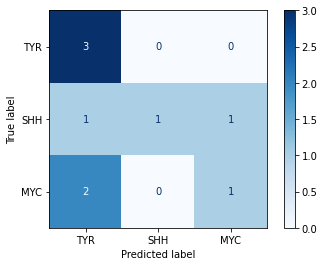

In [49]:
#============================================================================
# Plot confusion matrix for the trained model
#============================================================================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["TYR", "SHH","MYC"])
disp.plot(cmap="Blues")

We observed that changing the selection of i.e. the way to devide test and training data may 

influence the accuracy, which is reasonable. Here we fortunately reached a higher accuracy.

Try another test data set: test_sample_id_2.

In [50]:
# define train and test set
meta["subset"] = "train"
meta.loc[meta.SampleGeo.isin(test_sample_id_2), "subset"] = "test"

In [51]:
meta.groupby(["subset", "Class"]).SampleGeo.nunique()

subset  Class
test    0         3
        1         3
        2         3
train   0        15
        1        13
        2        12
Name: SampleGeo, dtype: int64

In [52]:
meta['subset']

dkfz_ATRT_10     train
dkfz_ATRT_101    train
dkfz_ATRT_11     train
dkfz_ATRT_12     train
dkfz_ATRT_14     train
dkfz_ATRT_151     test
dkfz_ATRT_152     test
dkfz_ATRT_153    train
dkfz_ATRT_154    train
dkfz_ATRT_155     test
dkfz_ATRT_156    train
dkfz_ATRT_157     test
dkfz_ATRT_158     test
dkfz_ATRT_159     test
dkfz_ATRT_16     train
dkfz_ATRT_160    train
dkfz_ATRT_161    train
dkfz_ATRT_162     test
dkfz_ATRT_163     test
dkfz_ATRT_164    train
dkfz_ATRT_165     test
dkfz_ATRT_166    train
dkfz_ATRT_167    train
dkfz_ATRT_168    train
dkfz_ATRT_169    train
dkfz_ATRT_17     train
dkfz_ATRT_170    train
dkfz_ATRT_171    train
dkfz_ATRT_172    train
dkfz_ATRT_173    train
dkfz_ATRT_25     train
dkfz_ATRT_30     train
dkfz_ATRT_32     train
dkfz_ATRT_36     train
dkfz_ATRT_41     train
dkfz_ATRT_43     train
dkfz_ATRT_46     train
dkfz_ATRT_47     train
dkfz_ATRT_48     train
dkfz_ATRT_49     train
dkfz_ATRT_51     train
dkfz_ATRT_6      train
dkfz_ATRT_7      train
dkfz_ATRT_7

This confirms we are not cheating!

In [53]:

target = (meta["Class"]).astype(int)

In [54]:
y_train = target[(meta.subset == "train")].values
y_test = target[(meta.subset == "test")].values
x_train = ge[meta[meta.subset == "train"].SampleGeo].transpose()
x_test = ge[meta[meta.subset == "test"].SampleGeo].transpose()

In [55]:
from sklearn.feature_selection import mutual_info_classif

In [56]:
midf = pd.DataFrame({
    "feature": x_train.columns,
    "mi": mutual_info_classif(x_train, y_train,)
}).sort_values("mi", ascending=False)

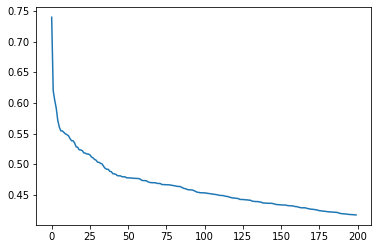

In [57]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(200), midf.mi.iloc[:200])

In [58]:
selected_genes = midf.feature.loc[midf.mi > 0.45]
len(selected_genes)

109

In [59]:
from autogluon.tabular import TabularPredictor
train_data = x_train.loc[:, selected_genes].copy()
train_data["Class"] = y_train
predictor = TabularPredictor(label="Class", path="good_quality_atrt").fit( 
    train_data=train_data,
    presets="good_quality_faster_inference_only_refit",
)

Presets specified: ['good_quality_faster_inference_only_refit']
Beginning AutoGluon training ...
AutoGluon will save models to "good_quality_atrt/"
AutoGluon Version:  0.3.1
Train Data Rows:    40
Train Data Columns: 109
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	3 unique label values:  [0, 1, 2]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Class Count: 3
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    10811.73 MB
	Train Data (Original)  Memory Usage: 0.17 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Genera

In [60]:
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, 
                             roc_auc_score, f1_score)
def performance_scores(y_true, y_pred_score, y_pred=None):
    # We can find which class has the highest score as its predicted class
    if y_pred is None:
        y_pred = y_pred_score.idxmax(axis=1)
        
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
        #"auroc": roc_auc_score(y_true, y_pred_score[:, 1], average="weighted",
        #                       multi_class="ovr"),
        "f1": f1_score(y_true, y_pred, average="weighted")
    }

In [61]:
test_data = x_test.loc[:, selected_genes].copy()
y_pred_score = predictor.predict_proba(test_data).values
y_pred = predictor.predict(test_data)
y_pred
performance_scores(y_test, y_pred_score, y_pred)

{'accuracy': 0.5555555555555556,
 'balanced_accuracy': 0.5555555555555555,
 'f1': 0.4666666666666667}

In [62]:
y_pred_score

array([[0.44832054, 0.17433333, 0.37734616],
       [0.4906995 , 0.19733334, 0.3119672 ],
       [0.44832054, 0.17433333, 0.37734616],
       [0.30545834, 0.38083333, 0.31370834],
       [0.44832054, 0.17433333, 0.37734616],
       [0.21958333, 0.48083332, 0.29958335],
       [0.44832054, 0.17433333, 0.37734616],
       [0.44832054, 0.17433333, 0.37734616],
       [0.44832054, 0.17433333, 0.37734616]], dtype=float32)

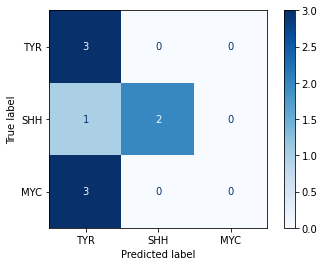

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(cm, display_labels=["TYR", "SHH","MYC"])
disp.plot(cmap="Blues")

In [75]:
featimp = predictor.feature_importance(train_data, num_shuffle_sets=10)
featimp[featimp.importance > 0].sort_values("p_value")

Computing feature importance via permutation shuffling for 191 features using 40 rows with 10 shuffle sets...
	1250.17s	= Expected runtime (125.02s per shuffle set)
	25.91s	= Actual runtime (Completed 10 of 10 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
209904_at,0.0650,0.012910,3.356928e-08,10,0.078267,0.051733
239260_at,0.0425,0.012076,7.294736e-07,10,0.054911,0.030089
241359_at,0.0400,0.012910,2.119869e-06,10,0.053267,0.026733
1553519_at,0.0650,0.021082,2.207929e-06,10,0.086666,0.043334
1553141_at,0.0525,0.018447,4.269026e-06,10,0.071457,0.033543
209508_x_at,0.0225,0.007906,4.269026e-06,10,0.030625,0.014375
214595_at,0.0225,0.007906,4.269026e-06,10,0.030625,0.014375
242082_at,0.0325,0.012076,6.729478e-06,10,0.044911,0.020089
214640_at,0.0325,0.012076,6.729478e-06,10,0.044911,0.020089
216780_at,0.0625,0.031732,7.677332e-05,10,0.095111,0.029889


We would also expect that **the cross-validation** is going to improve our algorithms for the classification. 

#### Future Direction 1: **Try Cross-Validation**

### Add Additional Features

Additional features from the meta file can be added to the analysis. 

However, following results tell us that they make almost no difference on the AutoML model accuracy. 

In [64]:
feature_columns = ['Age', 'Gender']

In [65]:
# Creating training and testing data. 
x_train = pd.concat([
    meta.loc[meta.subset == "train", feature_columns + ["SampleGeo"]].set_index("SampleGeo"),
    ge[meta[meta.subset == "train"].SampleGeo].transpose()
], axis=1)
y_train = target[(meta.subset == "train")].values
x_test = pd.concat([
    meta.loc[meta.subset == "test", feature_columns + ["SampleGeo"]].set_index("SampleGeo"),
    ge[meta[meta.subset == "test"].SampleGeo].transpose()
], axis=1)
y_test = target[(meta.subset == "test")].values

In [66]:
# for categorical variable, we simply encode it as 0 for male, 1 for female
x_train["Gender"] = (x_train.Gender == "F").astype(int)
x_test["Gender"] = (x_test.Gender == "F").astype(int)

In [67]:
# for missing data, we'll use the mean imputation
from sklearn.impute import SimpleImputer

imputer = SimpleImputer()
x_train_mi = imputer.fit_transform(x_train)
x_test_mi = imputer.transform(x_test)

In [68]:
midf = pd.DataFrame({
    "feature": x_train.columns,
    "mi": mutual_info_classif(x_train_mi, y_train)
}).sort_values("mi", ascending=False)

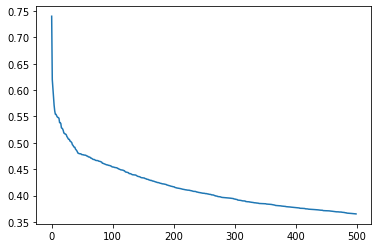

In [69]:
plt.plot(np.arange(500), midf.mi.iloc[:500])

In [70]:
selected_features = midf.loc[midf.mi > 0.42, "feature"]

In [71]:
# there are no features in the metadata selected based on MI
[x for x in meta.columns if x in selected_features]

[]

In [72]:
from autogluon.tabular import TabularPredictor

train_data = x_train[selected_features].copy()
train_data["Class"] = y_train

predictor = TabularPredictor(
    label="Class", path="good_quality_atrt_meta"
).fit( 
    train_data=train_data,
    presets="good_quality_faster_inference_only_refit",
)

Presets specified: ['good_quality_faster_inference_only_refit']
Beginning AutoGluon training ...
AutoGluon will save models to "good_quality_atrt_meta/"
AutoGluon Version:  0.3.1
Train Data Rows:    40
Train Data Columns: 191
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	3 unique label values:  [0, 1, 2]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Class Count: 3
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    10756.25 MB
	Train Data (Original)  Memory Usage: 0.31 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 G

In [73]:
test_data = x_test[selected_features].copy()
y_pred_score = predictor.predict_proba(test_data).values
y_pred = predictor.predict(test_data)

performance_scores(y_test, y_pred_score, y_pred)

{'accuracy': 0.3333333333333333,
 'balanced_accuracy': 0.3333333333333333,
 'f1': 0.16666666666666666}

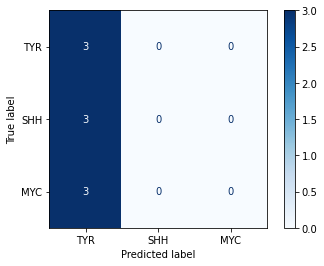

In [74]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(cm, display_labels=["TYR", "SHH","MYC"])
disp.plot(cmap="Blues")

#### Future Direction 2: Try other methods: e.g. add other features, etc. to improve the model.